<img src="https://raw.githubusercontent.com/aymiee/SantaBarbara/master/SB_1.jpg">

# Opening a Bookstore in Santa Barbara by way of Clustering 



### Determining the optimal neighborhood for a book store <br>in Santa Barbara, CA <br>using k-Means Clustering

<h2>1. Introduction

<h3> 1.1 Description and Discussion

The location of a bookstore will determine its success. In a wrong location, one will not attract the amount of customers needed to stay in business. A location near a busy restaurant, movie theatre or any place that will increase traffic in the vicinity of your store is ideal. Good location decisions can significantly boost a company's long-term performance. Since bookstores typically have low margins, other anciallary sales such as stationary, tee shirts, gifts, coffee, snacks are important to grow sales.  

I've lived in Santa Barbara for over sixteen years. One of my favorite past times was taking my daughter to the Border's book store downtown and spending a couple of hours browsing for books, watching my daughter partake in children events, perusing gifts, and enjoying a drink and snack or meet up with friends for coffee. Border closed its door back in 2011 and since then, we've frequented other book stores, but not with the same intensity. We don't linger for hours like we used to.   
    
Santa Barbara is a small city 90 miles north of Los Angeles. It's roughly 42 square miles compared to 468.7 sq miles of Los Angeles. Santa Barbara has roughly 30 neighborhoods. I put together a list of the neighborhood in Santa Barbara and used Google maps manually to capture the coordinates. Some may or may not have their own unique list of venues. I will use the K-Means Clustering algorithm to cluster the neighborhoods into similar groups. Next I will determine our ideal neighborhood by comparing the venues in each neighborhood.  Our ideal location will be next to busy venues to drive traffic in the book store.

The objective of this capstone project is to locate the optimal neighborhood for an independent book store using Foursquare API.

<h3> 1.2 Benefits

Santa Barbara, often regarded as the American Riviera, is home to a beautiful landscape and great climate for living, playing and working. Santa Barbara is well known for its strong sense of community, agricultural land, myriad of wineries, and attractive cultural and tourism opportunties. Lots of businesses open and sadly close (abruptly) in Santa Barbara. 
I hope that this analysis shows a new business owner where to look for real estate opportunities, saving time and allowing one to open new or more units faster.

<h2>2. Data Description

<h3> 2.1 Data Sources
    

Data for this project will come from 2 sources:

<li>Google Maps - The list of neighborhoods with their latitudes and longitudes were taken from the URL in Google maps.  I saved them into a csv file and uploaded the file to github.  <br>
    This data will help vizualize the neighborhoods  in Folium (a Python library used for visualizing geospatial data).  The coordinates will be passed to the Foursquare api to gather venue data for each neighborhood    
    
<li>Foursquare API will be used to obtain venue data for each neighborhood.  Once again, finding a location with busy venues to drive traffic to the book store will be ideal.  

<h3> 2.2 Neighborhood Candidate

There was not a one stop site to obtain all of the neighorhoods of Santa Barbara and their cooordinates.  So, I did the next best thing which was entering the neighborhoods into Google Maps and manually storing the coordinates in a csv file on github.  The file was read into a python dataframe: Neighboords, Latitude and Longitude. There were thrity neighbors that I indentified from my knowledge of living in Santa Barbara and from Google Maps.  Not all 30 neighborhoods will have venues.  Below is glance at a few of the row:

In [16]:
import pandas as pd

sb_data = pd.read_csv("https://raw.githubusercontent.com/aymiee/SantaBarbara/master/neighborhoods.csv")
sb_data.head()


,Neighborhood,Latitude,Longitude
0,Alta Mesa,34.408464,-119.725023
1,Bel Air,34.420665,-119.738266
2,Campanil,34.412598,-119.755684
3,Cielito,34.451463,-119.692851
4,Coast Village,34.423107,-119.647475


In [3]:
#!conda install -c conda-forge numpy

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
#!conda install -c conda-forge scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


I used geopy to return the graphical coordinates for Santa Barbara.  This will be used by Folium - a map rendering library- to create a map for Santa Barbara. 

In [17]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Santa Barbara, CA, USA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Santa Barbara, CA, USA are {}, {}.'.format(latitude, longitude))


The geographical coordinate of Santa Barbara, CA, USA are 34.4221319, -119.7026673.


Folium - a map rendering library - was used to show the neighborhoods in Santa Barbara.  

In [295]:
import folium # map rendering library

# create map of New York using latitude and longitude values
map_SB = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng,  label in zip(sb_data['Latitude'], sb_data['Longitude'], sb_data['Neighborhood']):
    #label = neighborhood
    #print(label)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
       ).add_to(map_SB)

map_SB

<img src="https://github.com/aymiee/SantaBarbara/blob/master/mapSB.PNG?raw=true">

Helper Functions

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
     
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [128]:
#function to repeat the same process to all the neighborhoods 
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #print(results)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venuesdf = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    print(nearby_venuesdf)
    nearby_venuesdf.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venuesdf)

I used the Four Square API to obtain data for each neighborhood.  I limited the venues to 50 within a 500 meter radius from each neighborhood.

In [253]:
sb_venues = getNearbyVenues(names=sb_data['Neighborhood'],
                                   latitudes=sb_data['Latitude'],
                                   longitudes=sb_data['Longitude']
                                  )

                   0          1           2  \
0          Alta Mesa  34.408464 -119.725023   
1          Alta Mesa  34.408464 -119.725023   
2          Alta Mesa  34.408464 -119.725023   
3          Alta Mesa  34.408464 -119.725023   
4          Alta Mesa  34.408464 -119.725023   
5          Alta Mesa  34.408464 -119.725023   
6          Alta Mesa  34.408464 -119.725023   
7          Alta Mesa  34.408464 -119.725023   
8          Alta Mesa  34.408464 -119.725023   
9          Alta Mesa  34.408464 -119.725023   
10         Alta Mesa  34.408464 -119.725023   
11         Alta Mesa  34.408464 -119.725023   
12         Alta Mesa  34.408464 -119.725023   
13         Alta Mesa  34.408464 -119.725023   
14         Alta Mesa  34.408464 -119.725023   
15         Alta Mesa  34.408464 -119.725023   
16         Alta Mesa  34.408464 -119.725023   
17         Alta Mesa  34.408464 -119.725023   
18         Alta Mesa  34.408464 -119.725023   
19         Alta Mesa  34.408464 -119.725023   
20         Al

In [256]:
print(sb_venues.shape)
sb_venues.head()

(926, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alta Mesa,34.408464,-119.725023,Elings Park,34.408819,-119.735243,Park
1,Alta Mesa,34.408464,-119.725023,Lazy Acres Market,34.400548,-119.721851,Grocery Store
2,Alta Mesa,34.408464,-119.725023,Rose Cafe,34.401510,-119.721121,Mexican Restaurant
3,Alta Mesa,34.408464,-119.725023,Szechuan Restaurant,34.402411,-119.723406,Chinese Restaurant
4,Alta Mesa,34.408464,-119.725023,Meun Fan Thai,34.401245,-119.721519,Thai Restaurant


This show the count of venues within each neighborhood.

In [257]:
sb_venues.groupby('Neighborhood').count()
#sb_venues

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alta Mesa,32,32,32,32,32,32
Bel Air,6,6,6,6,6,6
Campanil,4,4,4,4,4,4
Cielito,4,4,4,4,4,4
Coast Village,50,50,50,50,50,50
Downtown,50,50,50,50,50,50
East Beach,50,50,50,50,50,50
East Mesa,39,39,39,39,39,39
East San Roque,50,50,50,50,50,50


Interested in only neighborhoods with lots of venues to bring traffic to bookstore.  So, any neighborhood with less than 10 venues will be excluded

In [258]:
sb_venues_filtered = sb_venues[sb_venues.groupby('Neighborhood').Neighborhood.transform('count')>=10].copy() 
sb_venues_filtered=sb_venues_filtered.reset_index(drop=True)
sb_venues_filtered.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alta Mesa,32,32,32,32,32,32
Coast Village,50,50,50,50,50,50
Downtown,50,50,50,50,50,50
East Beach,50,50,50,50,50,50
East Mesa,39,39,39,39,39,39
East San Roque,50,50,50,50,50,50
East side,41,41,41,41,41,41
Hitchcock,49,49,49,49,49,49
Laguna,50,50,50,50,50,50


This gives a list of the neighborhoods I am dropping.  As expected, these neighborhoods are mostly residential; very little to no commercial business.  There would not be enough traffic to sustain a book store.

In [259]:
sb_dropped = sb_venues[sb_venues.groupby('Neighborhood').Neighborhood.transform('count')<10].copy() 
#sb_dropped=sb_venues_filtered.reset_index(drop=True)
sb_dropped=sb_dropped['Neighborhood'].unique()
sb_dropped=np.append(sb_dropped, 'Hope')
sb_dropped

array(['Bel Air', 'Campanil', 'Cielito', 'Eucalyptus Hill', 'Foothill',
       'Hidden Valley', 'Hope', 'Mission Canyon', 'West Mesa', 'Westside',
       'Hope'], dtype=object)

Only looking at neighborhoods with more than 10 venue categories

In [260]:
sb_venues_filtered.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alta Mesa,32,32,32,32,32,32
Coast Village,50,50,50,50,50,50
Downtown,50,50,50,50,50,50
East Beach,50,50,50,50,50,50
East Mesa,39,39,39,39,39,39
East San Roque,50,50,50,50,50,50
East side,41,41,41,41,41,41
Hitchcock,49,49,49,49,49,49
Laguna,50,50,50,50,50,50


In [44]:
#print('There are {} uniques categories.'.format(len(sb_venues['Venue Category'].unique())))
#sb_venues

In [261]:
print('There are {} uniques categories.'.format(len(sb_venues_filtered['Venue Category'].unique())))

There are 146 uniques categories.


In [262]:
# one hot encoding
sb_onehot = pd.get_dummies(sb_venues_filtered[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sb_onehot['Neighborhood'] = sb_venues_filtered['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sb_onehot.columns[-1]] + list(sb_onehot.columns[:-1])
sb_onehot = sb_onehot[fixed_columns]

sb_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Event Service,Farmers Market,Fast Food Restaurant,Fish Market,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym Pool,Harbor / Marina,Heliport,Historic Site,History Museum,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Laundry Service,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Movie Theater,Moving Target,Museum,Nail Salon,Nature Preserve,New American Restaurant,Noodle House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Resort,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stationery Store,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Alta Mesa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Alta Mesa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Alta Mesa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alta Mesa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alta Mesa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [263]:
sb_onehot.shape

(876, 147)

Group by neighborhood and by taking the mean of the frequcney of occurrence of each category

In [264]:
sb_grouped = sb_onehot.groupby('Neighborhood').mean().reset_index()
sb_grouped

,Neighborhood,Accessories Store,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bookstore,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Event Service,Farmers Market,Fast Food Restaurant,Fish Market,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym Pool,Harbor / Marina,Heliport,Historic Site,History Museum,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Laundry Service,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Motel,Movie Theater,Moving Target,Museum,Nail Salon,Nature Preserve,New American Restaurant,Noodle House,Optical Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Pub,Rental Car Location,Resort,Restaurant,Rock Climbing Spot,Rock Club,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Stationery Store,Steakhouse,Storage Facility,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Alta Mesa,0.000000,0.031250,0.00,0.00,0.00,0.000000,0.031250,0.000000,0.031250,0.031250,0.031250,0.000000,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.031250,0.031250,0.00,0.00,0.00,0.000000,0.00,0.031250,0.000000,0.000000,0.00,0.031250,0.00,0.0000,0.000000,0.031250,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.062500,0.00,0.000000,0.000000,0.00,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.093750,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.031250,0.00,0.000000,0.000000,0.031250,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.031250,0.000000,0.000000,0.00,0.031250,0.00,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.031250,0.031250,0.062500,0.00,0.062500,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.000000,0.031250,0.000000,0.031250,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.031250,0.000000,0.000000,0.031250,0.000000,0.000000,0.0000,0.031250,0.00,0.00,0.00,0.031250,0.000000,0.00,0.00,0.000000,0.00,0.00
1,Coast Village,0.000000,0.020000,0.00,0.00,0.00,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.02,0.00,0.000000,0.00,0.020000,0.000000,0.020000,0.02,0.020000,0.00,0.0000,0.000000,0.000000,0.020000,0.00,0.02,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.00,0.040000,0.040000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.060000,0.040000,0.00,0.000000,0.000000,0.00,0.040000,0.000000,0.040000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.000000,0.060000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.02,0.040000,0.00,0.000000,0.00,0.02,0.000000,0.000000,0.000000,0.040000,0.00,0.020000,0.000000,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.0000

In [265]:
sb_grouped.shape

(20, 147)

Listing the top 5 most common venues for each neighborhood

In [266]:
num_top_venues = 5

for hood in sb_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sb_grouped[sb_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alta Mesa----
                  venue  freq
0         Grocery Store  0.09
1           Pizza Place  0.06
2  Fast Food Restaurant  0.06
3              Pharmacy  0.06
4       Thai Restaurant  0.03


----Coast Village----
                venue  freq
0  Mexican Restaurant  0.06
1               Hotel  0.06
2          Steakhouse  0.04
3  Italian Restaurant  0.04
4            Pharmacy  0.04


----Downtown----
                 venue  freq
0  American Restaurant  0.08
1   Mexican Restaurant  0.06
2               Bakery  0.06
3               Garden  0.04
4       Ice Cream Shop  0.04


----East Beach----
                venue  freq
0             Brewery  0.10
1              Winery  0.10
2  Mexican Restaurant  0.08
3               Beach  0.06
4       Grocery Store  0.06


----East Mesa----
                  venue  freq
0         Grocery Store  0.08
1                 Beach  0.08
2                  Park  0.05
3  Fast Food Restaurant  0.05
4           Pizza Place  0.05


----East San Roque----
   

In [267]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Display the top 10 venues for each neighborhood based on mean frequency - popularity of each venue.

In [268]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sb_grouped['Neighborhood']

for ind in np.arange(sb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alta Mesa,Grocery Store,Pharmacy,Pizza Place,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Burger Joint,Shipping Store,Frozen Yogurt Shop,Sandwich Place
1,Coast Village,Mexican Restaurant,Hotel,Italian Restaurant,French Restaurant,Pharmacy,New American Restaurant,Steakhouse,Juice Bar,Ice Cream Shop,Gym
2,Downtown,American Restaurant,Bakery,Mexican Restaurant,Italian Restaurant,Garden,Ice Cream Shop,Coffee Shop,Theater,Hotel,Bed & Breakfast
3,East Beach,Brewery,Winery,Mexican Restaurant,Grocery Store,Beach,Wine Bar,Resort,Pet Store,Burger Joint,Seafood Restaurant
4,East Mesa,Grocery Store,Beach,Park,Pizza Place,Pharmacy,Fast Food Restaurant,Construction & Landscaping,Shipping Store,Frozen Yogurt Shop,Furniture / Home Store


# 3. Methodology & Analysis

The K-Means clustering was applied to the venue dataframe to put each neighborhood into similiar clusters.  This methodology requires one to initialize "K" - the number of clusters.  Determining the number of clusters is user-defined and it can be difficult.  I will use the Elbow Method to determine K - number of cluster. The method consists of plotting the variation as a function of the number of clusters. One would pick the elbow of the curve as the number of clusters to use. In the data below, there was not too much of an elbow.  

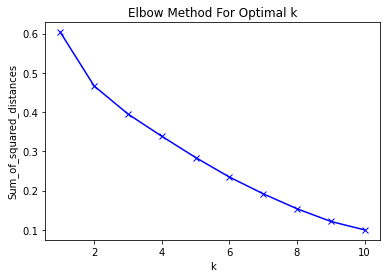

In [269]:
import matplotlib.pyplot as plt

sb_grouped_clustering = sb_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sb_grouped_clustering)
    #inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Since the Elbow Method was indeterminate, I tried the Silouette Score. It is used to study the distances between resulting clusters.  The score measure how close each point in one cluster is to points in the neighboring clusters.  

For n_clusters = 2, silhouette score is 0.3164271280373362)
For n_clusters = 3, silhouette score is 0.12205058752255118)
For n_clusters = 4, silhouette score is 0.15943812266216634)
For n_clusters = 5, silhouette score is 0.1748447549315748)
For n_clusters = 6, silhouette score is 0.16537176255664418)
For n_clusters = 7, silhouette score is 0.2255383332876469)
For n_clusters = 8, silhouette score is 0.2195473280192093)
For n_clusters = 9, silhouette score is 0.23001250089762873)


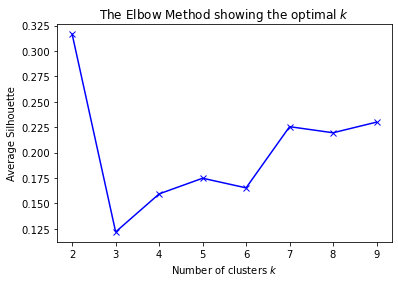

In [294]:
KS = range(2,10)
scores = []
#for n_clusters in range_n_clusters:
for ks in KS:
    clusterer = KMeans(n_clusters=ks)
    preds = clusterer.fit_predict(sb_grouped_clustering)
    centers = clusterer.cluster_centers_
    score = silhouette_score(sb_grouped_clustering, preds)
    scores.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(ks, score))
    
#for ks in KS:
    #fitx = KMeans(n_clusters=ks).fit(sb_grouped_clustering)
    #score = silhouette_score(sb_grouped_clustering, fitx.labels_)
    #scores.append(score)
    
#plt.figure(figsize=(11,8.5))
plt.plot(KS, np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('The Elbow Method showing the optimal $k$')
plt.show()

The appropriate number of clusters of neighborhoods = 7. 7 has a relatively high silhouette score and a relatively low inertia from the elbow method. 

In [271]:
# set number of clusters
kclusters = 7

#sb_grouped_clustering = sb_grouped.drop('Neighborhood', 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 5, 6, 0, 1, 0, 4, 5, 3], dtype=int32)

In [272]:
sb_dropped

array(['Bel Air', 'Campanil', 'Cielito', 'Eucalyptus Hill', 'Foothill',
       'Hidden Valley', 'Hope', 'Mission Canyon', 'West Mesa', 'Westside',
       'Hope'], dtype=object)

In [273]:
sb_data_filtered= sb_data[~sb_data['Neighborhood'].isin(sb_dropped)]
sb_data_filtered


,Neighborhood,Latitude,Longitude
0,Alta Mesa,34.408464,-119.725023
4,Coast Village,34.423107,-119.647475
5,Downtown,34.422050,-119.708637
6,East Beach,34.418564,-119.681380
7,East Mesa,34.400292,-119.715212
8,East San Roque,34.444448,-119.731579
9,East side,34.400331,-119.714883
13,Hitchcock,34.432211,-119.744874
15,Laguna,34.427191,-119.700211
16,Lower Riviera,34.434713,-119.707776


The Cluster Labels were added to the Dataframe.

In [274]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sb_merged =  sb_data_filtered

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
sb_merged = sb_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


sb_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alta Mesa,34.408464,-119.725023,0,Grocery Store,Pharmacy,Pizza Place,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Burger Joint,Shipping Store,Frozen Yogurt Shop,Sandwich Place
4,Coast Village,34.423107,-119.647475,1,Mexican Restaurant,Hotel,Italian Restaurant,French Restaurant,Pharmacy,New American Restaurant,Steakhouse,Juice Bar,Ice Cream Shop,Gym
5,Downtown,34.422050,-119.708637,5,American Restaurant,Bakery,Mexican Restaurant,Italian Restaurant,Garden,Ice Cream Shop,Coffee Shop,Theater,Hotel,Bed & Breakfast
6,East Beach,34.418564,-119.681380,6,Brewery,Winery,Mexican Restaurant,Grocery Store,Beach,Wine Bar,Resort,Pet Store,Burger Joint,Seafood Restaurant
7,East Mesa,34.400292,-119.715212,0,Grocery Store,Beach,Park,Pizza Place,Pharmacy,Fast Food Restaurant,Construction & Landscaping,Shipping Store,Frozen Yogurt Shop,Furniture / Home Store


In [275]:
sb_merged['Cluster Labels'] = sb_merged['Cluster Labels'].fillna(0).astype(int)
sb_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alta Mesa,34.408464,-119.725023,0,Grocery Store,Pharmacy,Pizza Place,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Burger Joint,Shipping Store,Frozen Yogurt Shop,Sandwich Place
4,Coast Village,34.423107,-119.647475,1,Mexican Restaurant,Hotel,Italian Restaurant,French Restaurant,Pharmacy,New American Restaurant,Steakhouse,Juice Bar,Ice Cream Shop,Gym
5,Downtown,34.422050,-119.708637,5,American Restaurant,Bakery,Mexican Restaurant,Italian Restaurant,Garden,Ice Cream Shop,Coffee Shop,Theater,Hotel,Bed & Breakfast
6,East Beach,34.418564,-119.681380,6,Brewery,Winery,Mexican Restaurant,Grocery Store,Beach,Wine Bar,Resort,Pet Store,Burger Joint,Seafood Restaurant
7,East Mesa,34.400292,-119.715212,0,Grocery Store,Beach,Park,Pizza Place,Pharmacy,Fast Food Restaurant,Construction & Landscaping,Shipping Store,Frozen Yogurt Shop,Furniture / Home Store


In [276]:
sb_merged.groupby('Cluster Labels').mean()

,Latitude,Longitude
Cluster Labels,,
0,34.403029,-119.718373
1,34.432741,-119.712220
2,34.437763,-119.702240
3,34.421429,-119.704788
4,34.438803,-119.747020
5,34.422089,-119.702215
6,34.418187,-119.685265


Folium was used to illustrate the clusters.

In [292]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sb_merged['Latitude'], sb_merged['Longitude'], sb_merged['Neighborhood'], sb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<img src="https://github.com/aymiee/SantaBarbara/blob/master/clustersSB.PNG?raw=true"></a>

In [279]:
sb_merged.loc[sb_merged['Cluster Labels'] == 0, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alta Mesa,Grocery Store,Pharmacy,Pizza Place,Fast Food Restaurant,Convenience Store,Chinese Restaurant,Burger Joint,Shipping Store,Frozen Yogurt Shop,Sandwich Place
7,East Mesa,Grocery Store,Beach,Park,Pizza Place,Pharmacy,Fast Food Restaurant,Construction & Landscaping,Shipping Store,Frozen Yogurt Shop,Furniture / Home Store
9,East side,Beach,Pizza Place,Grocery Store,Park,Fast Food Restaurant,Pharmacy,Playground,Furniture / Home Store,Shipping Store,Frozen Yogurt Shop


In [280]:
sb_merged.loc[sb_merged['Cluster Labels'] == 1, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Coast Village,Mexican Restaurant,Hotel,Italian Restaurant,French Restaurant,Pharmacy,New American Restaurant,Steakhouse,Juice Bar,Ice Cream Shop,Gym
8,East San Roque,Motel,Italian Restaurant,Grocery Store,Mexican Restaurant,Pizza Place,American Restaurant,Coffee Shop,Sandwich Place,Hotel,Gas Station
20,Oak Park,Coffee Shop,Pizza Place,American Restaurant,Chinese Restaurant,Liquor Store,BBQ Joint,Mexican Restaurant,Italian Restaurant,Salon / Barbershop,Construction & Landscaping
22,Samarkand,Italian Restaurant,Coffee Shop,Grocery Store,Pizza Place,Mexican Restaurant,Gas Station,Sushi Restaurant,Chinese Restaurant,Sandwich Place,French Restaurant
24,Upper East,Coffee Shop,Italian Restaurant,Pizza Place,Breakfast Spot,Grocery Store,Mexican Restaurant,Park,Convenience Store,Hotel,American Restaurant


In [281]:
sb_merged.loc[sb_merged['Cluster Labels'] == 2, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Riviera,Park,Liquor Store,Indie Movie Theater,New American Restaurant,Church,Rock Club,Tea Room,Tennis Stadium,Concert Hall,Construction & Landscaping


In [283]:
sb_merged.loc[sb_merged['Cluster Labels'] == 3, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Lower Riviera,Hotel,Park,Breakfast Spot,Convenience Store,Liquor Store,Indie Movie Theater,Lounge,Motel,Garden,Church
27,West Beach,Hotel,Seafood Restaurant,Harbor / Marina,Park,Gym,Bed & Breakfast,Italian Restaurant,Motel,Brewery,Mexican Restaurant


In [284]:
sb_merged.loc[sb_merged['Cluster Labels'] == 4, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Hitchcock,Sandwich Place,Bakery,Donut Shop,Mexican Restaurant,Breakfast Spot,Golf Course,Bank,Motel,Grocery Store,Mobile Phone Shop
23,San Roque,Fast Food Restaurant,Bakery,Bank,Breakfast Spot,Shipping Store,Mexican Restaurant,Motel,Pizza Place,Gym,Donut Shop
25,Upper State,Gym,Pizza Place,American Restaurant,Grocery Store,Sandwich Place,Rental Car Location,Chinese Restaurant,Coffee Shop,Bank,Donut Shop


In [285]:
sb_merged.loc[sb_merged['Cluster Labels'] == 5, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown,American Restaurant,Bakery,Mexican Restaurant,Italian Restaurant,Garden,Ice Cream Shop,Coffee Shop,Theater,Hotel,Bed & Breakfast
15,Laguna,Bakery,Yoga Studio,Sushi Restaurant,American Restaurant,Coffee Shop,Deli / Bodega,Garden,Ice Cream Shop,Mexican Restaurant,New American Restaurant
17,Lower State,Burger Joint,Bar,American Restaurant,Coffee Shop,Sandwich Place,Breakfast Spot,Farmers Market,Yoga Studio,Juice Bar,Furniture / Home Store


In [286]:
sb_merged.loc[sb_merged['Cluster Labels'] == 6, sb_merged.columns[[0] + list(range(4, sb_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,East Beach,Brewery,Winery,Mexican Restaurant,Grocery Store,Beach,Wine Bar,Resort,Pet Store,Burger Joint,Seafood Restaurant
18,Milpas,Mexican Restaurant,Brewery,Grocery Store,Pizza Place,Fast Food Restaurant,Pharmacy,Sandwich Place,Italian Restaurant,Winery,Football Stadium
26,Waterfront,Hotel,Seafood Restaurant,Beach,Brewery,Winery,Bakery,Bed & Breakfast,Breakfast Spot,New American Restaurant,Mexican Restaurant


# Results and Conclusion

Based on the clusters, the two clusters with the most venues would be Cluster 5 and Cluster 1.  According to <a href='https://santabarbaraca.com/press_releases/santa-barbara-south-coast-visitor-profile-study-shows-tourism-injects-1-9-billion-santa-barbara-economy/'>SantaBarbara.com</a>, The Santa Barbara South Coast welcomed an estimated 7.2 million total visitors between 2016 and 2017. The most common activities were dining, going to the beach, shopping and wine tasting. All of these activities are in walking distance of Cluster 5.

In [289]:
sb_venues.loc[sb_venues['Venue Category'] == 'Theater', ['Neighborhood', 'Venue']]

,Neighborhood,Venue
114,Downtown,The Granada Theater
143,Downtown,Lobero Theatre
408,Laguna,The Granada Theater
413,Laguna,Lobero Theatre
509,Lower State,Lobero Theatre


In [290]:
sb_venues.loc[sb_venues['Venue Category'] == 'Farmers Market', ['Neighborhood', 'Venue']]

,Neighborhood,Venue
441,Laguna,Santa Barbara Certified Farmers Market
477,Lower State,Santa Barbara Certified Farmers Market
482,Lower State,Santa Barbara Farmers Market


In [291]:
sb_venues.loc[sb_venues['Venue Category'] == 'Bookstore', ['Neighborhood', 'Venue']]

,Neighborhood,Venue
236,East San Roque,Chaucer's Books
316,East side,Mesa Bookstore
612,Samarkand,Chaucer's Books


In the neighbor of Cluster 5: Downtown, Laguna and Lower State, the choice would be between Lower State and Downtown.  I know there's already a well established book store in the East San Roque (Cluster 1).  What foursquare doesn't show is another book store in Downtown called Book Den. Lower State is the better option as it's also the most touristy. According to Google Quick Facts: "The leafy streets of Lower State are lined with trendy eateries serving New American, Mexican, and pan-Asian fare, plus craft breweries and winery tasting rooms. National fashion chains cluster in the courtyards of the Paseo Nuevo shopping center, and buskers play amid stalls selling organic produce and flowers at the weekly Santa Barbara Farmers Market. The kid-friendly MOXI museum has interactive science exhibits." 

<B>Disclaimer</B>: this was just an exercise in using K-Means Clustering and accessing Foursquare API data.  There's other criteria that is also important such as rent.  Rent downtown and on Lower State street is very high.  You would get more traffic, but you'd be paying a lot in rent in Cluster 5 as oppose to Cluster 1. Which brings be back to the original statement that bookstores typically have low margins.  Other anciallary sales such as stationary, tee shirts, gifts, coffee, snacks are important to grow sales.